Links:
- github sklearn https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/linear_model/_logistic.py

In [2]:
import numpy as np
from scipy.optimize import minimize
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

# INITIAL LOGIC

vot eto kak-to nado sdelat' ne ebu kak:

- penalty 
- dual
- tol 
- C 
- fit_intercept 
- intercept_scaling
- class_weight
- random_state
- solver
- max_iter
- multi_class
- verbose
- warm_start
- n_jobs
- l1_ration

# Intercept

The idea behind adding intercept is to account for the bias in the linear equation, which originally underlines logistic regression. If we do not add it, we are taking an assumption, that our probability of observing output equal to 1 is 0.5 when all the weights are 0. From mathematical point of view, we have an equation of the logistic regression model, which is:

$ P(y=1|x) = sigmoid(w_0 + \sum^n_{i=1} w_i x_i) $, where

$ P(y=1|x) $ - probability of classifying our output as 1,

$ \sum^n_{i=1} w_i x_i $ - logit function and

$ w_o $ - intercept term.


To include the intercept to our model, we create an additional feature with constant value of ones and add it ot the input feature matrix. The resulting matrix will have one extra columns of ones, which then will multiply wirh $w_0$ and will allow us to account intercept.

In [ ]:
def add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.hstack((intercept, X))

# Sigmoid

Firstly, we can dig into activation function of Logistic Regression. 

An activation function is a mathematical function that controls the output of regression. Activation is responsible for adding non-linearity to the output of a neural network model. Without an activation function, a neural network is simply a linear regression.

Sigmoid is a mathematical function that takes any real number and maps it to a probability between 1 and 0. That idea lies behind the Logistic Regression, where we predict a probabilty of classifier to be either 1 or 0 based on the feature'  values and make a classification.

$ \text{Logit Function} = log(\dfrac{p}{1-p}) = w_0 + w_1 x_1 + w_2 x_2 + ... + w_n x_n $

We can transform it to a matrix equation which will look like this:

$ \text{Logit Function} = log(\dfrac{p}{1-p}) = W^T X $

To calculate the probability we should express `p` variable from this equation:

$ p = \dfrac{1}{1 + e^{-W^T X}} $

Now we can code this equation as a `sigmoid` function

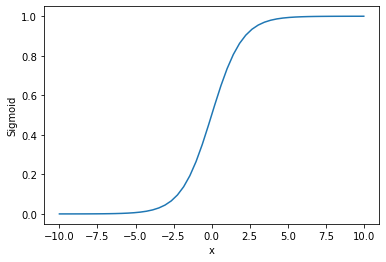

In [9]:
# HIDE

x = np.linspace(-10, 10, 50)   
p = sigmoid(x)
plt.xlabel('x') 
plt.ylabel('Sigmoid')  
plt.plot(x, p) 
plt.show()

In [6]:
def sigmoid(z):
        return 1 / (1 + np.exp(-z))

# Cost function

A cost function is needed to understand how bad our model is. It's needed to undertand, which features require more weights to have a better fit of our model and increase our estimation of Y based on X. 

In logistic regression we mainly use 2 different cost functions: `L2` (Ridge) which is default and `L1` (Lasso). The difference between them is the penalty term.

`L2` regularization adds the squared error to our formula as a penaty and helps to avoid underfitting, while `L1` adds the absolute value makes coefficients with lower importance to zero and removing some features. 

The formula for it is:

$ L_2 = \sum^n_{i=1}  (y_i - \sum^p_{j=1} x_{ij} \beta_j)^2 + \lambda \sum^p_{j=1} \beta^2_j $

$ L_1 = \sum^n_{i=1}  (y_i - \sum^p_{j=1} x_{ij} \beta_j)^2 + \lambda \sum^p_{j=1} | \beta_j | $

Knowing this, we can strat writing our function to define cost functions


In [ ]:
def cost_function(self, w, X, y):
    m = len(y)
    h = self.sigmoid(np.dot(X, w))
    if self.penalty == 'l1': # L1 regularization
        reg_term = self.C * np.sum(np.abs(w))
    elif self.penalty == 'l2': # L2 regularization
        reg_term = 0.5 * self.C * np.sum(w**2)
    else:  # None penalty term, i.e. OLS cost function
        reg_term = 0
    cost = -np.sum(y * np.log(h) + (1 - y) * np.log(1 - h)) / m + reg_term
    return cost

But one more thing we have is `elastic net`. The idea behind this is that we can mix both regularizations together to have a more advanced penalty term. By doing this we define $ l_1 \text{ }ratio $ which controls the input of both `L1` and `L2` regularizations to our custome regularization by stating the relationship between them. So the final function will look as follow:

In [1]:
def cost_function(self, w, X, y):
    m = len(y)
    h = self.sigmoid(np.dot(X, w))
    if self.penalty == 'l1': # L1 regularization
        reg_term = self.C * np.sum(np.abs(w))
    elif self.penalty == 'l2': # L2 regularization
        reg_term = 0.5 * self.C * np.sum(w**2)
    elif self.penalty == 'elasticnet': # Elastic net regularization
        reg_term = self.C * (self.l1_ratio * np.sum(np.abs(w)) + 0.5 * (1 - self.l1_ratio) * np.sum(w**2))
    else:  # None penalty term, i.e. OLS cost function
        reg_term = 0
    cost = -np.sum(y * np.log(h) + (1 - y) * np.log(1 - h)) / m + reg_term
    return cost

# Gradient and gradient descent

Gradient is a critical component of in optimization process of a model. It is a vector of partial derivatives of a cost function with respect to the weights of the features. So basically gradient  shows the direction of the steepest increase of the function and indicates the rate of change in that direction. 

To calculate gradient of the function, we can use the formula for the vectorized form of it, which is:

$ \nabla J = \dfrac{1}{m} \cdot X^T \cdot (h(X \cdot w) - y) $, where

$X$ - input matrix,

$y$ - vector of actual class labels and

$h(X \cdot w)$ - vector of predicted probabilities

Knowing this, we can write the first part of `gradient` function

In [ ]:
def gradient(self, w, X, y):
        m = len(y)
        h = self._sigmoid(np.dot(X, w))
        gradient = np.dot(X.T, (h - y)) / m

Then we need to take into account what cost function do we use, because it will affect our regularizatiom term. Also, we need to take into account that we also have 1 more parameter of our model, which is C. C is a inverse regularization strength. It controls the balance of our model between under- and overfitting. The lower value of C we take, the stronger is our regularization, i.e. the more we prevent overfitting of our model by reducing its complexity. This parameter is being accounted by multiplying its value on regularization term for every cost function in gradient descent.

The next step is to calculate the value of regularization term based on cost function we have chosen before. If we decided to use L1 (Lasso) regularization, the formula for it would be 

$ L_1 = C \cdot \sum |w_i| $

and after calculating the gradient we will receive

$ \dfrac{\partial L_1}{\partial w_i} = C \cdot sgn(w_i) $

Here we use a signum of the $w_i$, which return 1 if the number is greater than 0, -1 if the number is lower and 0 if 0. That is because when we calculate $\dfrac{\partial |w_i|}{\partial w_i}$ we get just the sign of the fraction.

If the cost function we are using is L2 (Ridge), than our goal is to find the derivative of our regularization term

$ L_2 = 0.5 \cdot C \cdot \sum w_i^2 $

that is 

$ \dfrac{\partial L_2}{\partial w_i} = C \cdot w_i $

We are multiplying our regularization term by 0.5 here (and also while writing the cost function function) to simplify our gradient expression, as it will cancel our the multiplication by 2, which comes from taking the derivative of squared value of weights. 

Finally, for elasticnet it will just the combination of both regularization terms with respect to our l1 ratio.

The complete code will result in this:

In [ ]:
def gradient(self, w, X, y):
        m = len(y)
        h = self.sigmoid(np.dot(X, w))
        gradient = np.dot(X.T, (h - y)) / m

        if self.penalty == 'l1':
            reg_term = self.C * np.sign(w)
        elif self.penalty == 'l2':
            reg_term = self.C * w
        elif self.penalty == 'elasticnet':
            reg_term = self.C * (self.l1_ratio * np.sign(w) + (1 - self.l1_ratio) * w)
        else:  # none
            reg_term = 0
        return gradient + reg_term

# Solver

Now we come to the main thing of building a regression: solver functions.

Solver is needed to find the optimal weights for our model. Overall, there are 6 solvers the can possibly be applied to logistic regression: lbfgs, liblinear, newton-cg, sag and saga. The choice of the algorithm depends on the penalty chosen, because most of them does not support all the available cost functions.

Let's analyze all of them one by one

## Gradient descent


To apply the gradient descent algorithm, we need to create a loop of finding gradient until we met the optimal solution. Also we can add learning rate there to control the adjustment of the weights to the gradient. The lower we set our learning rate, the more accurate our result would be, but also the more time and power will it take to calculate the final output. 

In [ ]:
def gradient_descent(self, X, y, w):
        for _ in range(self.max_iter):
            gradient = self.gradient(w, X, y)
            w -= self.learning_rate * gradient
        return w

## SAG

Stochastic Average Gradient Descent (or SAG) is an optimization algorithm which iterates a random sample of the dataset to find the optimal state of the model. It is well suited for a large-scaled datasets and supports L2 regularization or None.

SAG mainly have 2 steps:

1. Calculate Stochastic Gradient Descent (SGD). In alternative to standart gradient descent, SGD uses randomly choosen point at each iteration to calculate the gradient descent. It brings more noise to the, but helps to reduce the time of calculation.
2. Averaging the gradient values. To deal with the noise problem, SAG takes the average values of gradients and updates the parameter.

Mathematically, we have and objective function as a sum of functions in every point devided by the number of points, i.e.

$ L_w = \dfrac{1}{m} \cdot \sum L_i(w) $

We calculate the gradients for each $L_i$ and than update the value of average gradient

$ G = G + \dfrac{1}{m} (g_i(w) - g_i(w_{old})) $

After this, we update the weights with respect to learning rate

$ w = w - \eta \cdot G $

But calculating gradients in points also applies some restrictions on the solver. For example, it cannot work with L1 and elastic net regularizations. Dut to the fact, that the regularization term in this models is the absolute value of weights, the function is not smooth, which can affect the result and they can vary a much based on random sampling results.

To implement the logic of SAG in code, we need to create a storage for sum of gradients and also initialize a matrix to store values of gradients.

In [1]:
def sag(self, X, y, w):
    m, n = X.shape
    sum_gradients = np.zeros_like(w)
    gradients = np.zeros((m, n))

Then we need to make a stated in max_iter amount of iteration through all points. During each iteration we calculate new gradient for the point and add regularization term there. After this we calculate the add the difference between old and new gradient to the sum of gradients and update vector of weights using the average gradient multiplied by learning rate.

In [ ]:
def sag(self, X, y, w):
    m, n = X.shape
    sum_gradients = np.zeros_like(w)
    gradients = np.zeros((m, n))

    for epoch in range(self.max_iter):
        for i in range(m):
            old_gradient = gradients[i]
            new_gradient = (self.sigmoid(np.dot(X[i], w)) - y[i]) * X[i]
            if self.penalty == 'l2':
                reg_term = self.C * w
            else:  # none
                reg_term = 0
            new_gradient += reg_term
            gradients[i] = new_gradient
            sum_gradients += new_gradient - old_gradient
            w -= self.learning_rate * sum_gradients / m
    return w

# SAGA

Stochastic Average Gradient with Asymptotic Variance Reduction (SAGA) is a solver that can deal with the problem of non-smoothness of L1 regularization in SAG. The rule of updating gradients here uses proximal step while updating weights. 

https://math.stackexchange.com/questions/1961888/the-proximal-operator-of-the-l-1-norm-function
https://math.stackexchange.com/questions/1766811/l-1-regularized-unconstrained-optimization-problem

The optimization problem here is:

$ \text{Prox}(w) = \text{argmin}_u \text{  }{ \dfrac{1}{2} \cdot ||w - u||^2 + \lambda \cdot ||u||} $

We can understand, that $u$ here can be either positive, negative or zero (почему??? я понял основную логику, но почему берем сигнум не особо ).

For $u>0$ the derivative vanishes to $u_i = w_i - \lambda$ and holds for every $w_i>\lambda$. We apply the same logic to derive $u_i = w_i + \lambda$ for $u<0$. Finally, for 

In [ ]:
def saga(self, X, y, w):
    m, n = X.shape
    sum_gradients = np.zeros_like(w)
    gradients = np.zeros((m, n))
    
    for epoch in range(self.max_iter):
        for i in range(m):
            old_gradient = gradients[i]
            new_gradient = (self.sigmoid(np.dot(X[i], w)) - y[i]) * X[i]
            if self.penalty == 'l1':
                reg_term = self.C * np.sign(w)
            elif self.penalty == 'l2':
                reg_term = self.C * w
            elif self.penalty == 'elasticnet':
                reg_term = self.C * (self.l1_ratio * np.sign(w) + (1 - self.l1_ratio) * w)
            else:  # none
                reg_term = 0
            new_gradient += reg_term
            gradients[i] = new_gradient
            sum_gradients += new_gradient - old_gradient
            w -= self.learning_rate * sum_gradients / m
        if self.penalty == 'l1':
            w = np.sign(w) * np.maximum(np.abs(w) - self.C * self.learning_rate, 0)
    return w

# Newton-CG

Newton-Conjugate Gradient is a concept that combines both Newton's and Conjugate Gradient methods. 

The idea behind Newton's method is an optimization algorithm that uses Hessian matrix (the matrix of second-order derivatives) to optimize the function. It recalculates the values of minimum of the function by taking steps in the direction of inverse Hessian multiplied by gradient matrix.

The scheme for this iterations is 

$ w_{i+1} = w_i - \gamma [\nabla^2 w_i]^T \cdot \nabla w_i $, where

w - estimation for the vector of weights, 

$\gamma$ - size of the step.

Conjugate Gradient method (add math here)

As said before, Newton-CG combines both this algorithms and calculates the product of Hessian and gradient matrixes. 

To implement this algorithm in code, we firstly need to define a function to calculate Hessian matrix.
Here we firstly calculate sigmoid function and then calculate the Hessian. After this, we are adding regularization term for L2 using diagonal of the matrix, because it will help us to add squared sum of weights, as it should be in formula.

In [ ]:
def hessian(self, w, X, y):
    h = self.sigmoid(np.dot(X, w))
    hessian = np.dot(((h * (1 - h)).reshape(-1, 1) * X).T, X)
    
    if self.penalty == 'l2':
        reg_term = self.C * np.diag(w)
    else:  # none
        reg_term = 0
    return hessian + reg_term

The next step is to write code for the solver itself. For each iteration in max_iter values, we calculate gradient, hessian and then the step direction. The step direction is calculated as the product of these two matrixes.

In [ ]:
def newton_cg(self, X, y, w):
    for _ in range(self.max_iter):
        gradient = self.gradient(w, X, y)
        hessian = self.hessian(w, X, y)
        step_direction = np.linalg.solve(hessian, gradient)
        w -= self.learning_rate * step_direction
    return w

# Final code

In [9]:
# Working for now

class CustomLogisticRegression:
    def __init__(self, penalty='l2', tol=1e-4, C=1.0, fit_intercept=True,
                 intercept_scaling=1, class_weight=None, random_state=None,
                 solver='lbfgs', max_iter=100, warm_start=False, n_jobs=None,
                 l1_ratio=None, learning_rate=0.1):
        self.penalty = penalty
        self.tol = tol
        self.C = C
        self.fit_intercept = fit_intercept
        self.intercept_scaling = intercept_scaling
        self.class_weight = class_weight
        self.random_state = random_state
        self.solver = solver
        self.max_iter = max_iter
        self.warm_start = warm_start
        self.n_jobs = n_jobs
        self.l1_ratio = l1_ratio
        self.learning_rate = learning_rate

    def add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.hstack((intercept, X))

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def cost_function(self, w, X, y):
        m = len(y)
        h = self.sigmoid(np.dot(X, w))
        if self.penalty == 'l1':
            reg_term = self.C * np.sum(np.abs(w))
        elif self.penalty == 'l2':
            reg_term = 0.5 * self.C * np.sum(w**2)
        elif self.penalty == 'elasticnet':
            reg_term = self.C * (self.l1_ratio * np.sum(np.abs(w)) + 0.5 * (1 - self.l1_ratio) * np.sum(w**2))
        else:  # none
            reg_term = 0
        cost = -np.sum(y * np.log(h) + (1 - y) * np.log(1 - h)) / m + reg_term
        return cost

    def gradient(self, w, X, y):
        m = len(y)
        h = self.sigmoid(np.dot(X, w))
        gradient = np.dot(X.T, (h - y)) / m

        if self.penalty == 'l1':
            reg_term = self.C * np.sign(w)
        elif self.penalty == 'l2':
            reg_term = self.C * w
        elif self.penalty == 'elasticnet':
            reg_term = self.C * (self.l1_ratio * np.sign(w) + (1 - self.l1_ratio) * w)
        else:  # none
            reg_term = 0
        return gradient + reg_term

    def gradient_descent(self, X, y, w):
        for _ in range(self.max_iter):
            gradient = self.gradient(w, X, y)
            w -= self.learning_rate * gradient
        return w

    def sag(self, X, y, w):
        m, n = X.shape
        sum_gradients = np.zeros_like(w)
        gradients = np.zeros((m, n))

        for epoch in range(self.max_iter):
            for i in range(m):
                old_gradient = gradients[i]
                new_gradient = (self.sigmoid(np.dot(X[i], w)) - y[i]) * X[i]
                if self.penalty == 'l1':
                    reg_term = self.C * np.sign(w)
                elif self.penalty == 'l2':
                    reg_term = self.C * w
                elif self.penalty == 'elasticnet':
                    reg_term = self.C * (self.l1_ratio * np.sign(w) + (1 - self.l1_ratio) * w)
                else:  # none
                    reg_term = 0
                new_gradient += reg_term
                gradients[i] = new_gradient
                sum_gradients += new_gradient - old_gradient
                w -= self.learning_rate * sum_gradients / m
        return w
    
    def hessian(self, w, X, y):
        h = self.sigmoid(np.dot(X, w))
        hessian = np.dot(((h * (1 - h)).reshape(-1, 1) * X).T, X)

        if self.penalty == 'l1':
            reg_term = self.C * np.diag(np.sign(w))
        elif self.penalty == 'l2':
            reg_term = self.C * np.diag(w)
        elif self.penalty == 'elasticnet':
            reg_term = self.C * np.diag(self.l1_ratio * np.sign(w) + (1 - self.l1_ratio) * w)
        else:  # none
            reg_term = 0
        return hessian + reg_term
    
    
    def newton_cg(self, X, y, w):
        for _ in range(self.max_iter):
            gradient = self.gradient(w, X, y)
            hessian = self.hessian(w, X, y)
            step_direction = np.linalg.solve(hessian, gradient)
            w -= self.learning_rate * step_direction
        return w
    
    def lbfgs(self, X, y, w_init):
        result = minimize(
        fun=self._cost_function,
        x0=w_init,
        args=(X, y),
        method='L-BFGS-B',
        jac=self._gradient,
        tol=self.tol,
        options={'maxiter': self.max_iter},
    )
        return result.x


    def saga(self, X, y, w):
        m, n = X.shape
        sum_gradients = np.zeros_like(w)
        gradients = np.zeros((m, n))

        for epoch in range(self.max_iter):
            for i in range(m):
                old_gradient = gradients[i]
                new_gradient = (self.sigmoid(np.dot(X[i], w)) - y[i]) * X[i]
                if self.penalty == 'l1':
                    reg_term = self.C * np.sign(w)
                elif self.penalty == 'l2':
                    reg_term = self.C * w
                elif self.penalty == 'elasticnet':
                    reg_term = self.C * (self.l1_ratio * np.sign(w) + (1 - self.l1_ratio) * w)
                else:  # none
                    reg_term = 0
                new_gradient += reg_term
                gradients[i] = new_gradient
                sum_gradients += new_gradient - old_gradient
                w -= self.learning_rate * sum_gradients / m
            if self.penalty == 'l1':
                w = np.sign(w) * np.maximum(np.abs(w) - self.C * self.learning_rate, 0)
        return w


    def fit(self, X, y):
        if self.fit_intercept:
            X = self.add_intercept(X)
        w_init = np.zeros(X.shape[1])

        if self.solver == 'gradient_descent':
            self.w_ = self.gradient_descent(X, y, w_init)
        elif self.solver == 'sag':
            self.w_ = self.sag(X, y, w_init)
        elif self.solver == 'newton_cg':
            self.w_ = self.newton_cg(X, y, w_init)
        elif self.solver == 'lbfgs':
            self.w_ = self.lbfgs(X, y, w_init)
        elif self.solver == 'saga':
            self.w_ = self.saga(X, y, w_init)
        else:
            raise ValueError(
                f"Solver '{self.solver}' not supported. Use 'gradient_descent', 'sag', 'newton_cg', 'lbfgs', or 'saga'."
            )


    def predict_proba(self, X):
        if self.fit_intercept:
            X = self.add_intercept(X)
        return self.sigmoid(np.dot(X, self.w_))


    def predict(self, X):
        proba = self.predict_proba(X)
        return (proba >= 0.5).astype(int)


# Checker

In [13]:
df = pd.read_csv('https://raw.githubusercontent.com/5x12/ml-cookbook/master/supplements/data/heart.csv')

X = df.iloc[:, :-1].values
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, #independent variables
                                                    y, #dependent variable
                                                    random_state = 3
                                                   )

logreg = CustomLogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.5136186770428015


In [15]:
logistic = LogisticRegression(solver='lbfgs')
logistic.fit(X_train, y_train)
y_pred = logistic.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.8287937743190662
